In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import e variáveis iniciais

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [4]:
dataset_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/rede neural')

dataset_train_dir = os.path.join(dataset_dir, "treino")
dataset_train_desfo_len = len(os.listdir(os.path.join(dataset_train_dir, "desmatamento")))
dataset_train_not_desfo_len = len(os.listdir(os.path.join(dataset_train_dir, "nao-desmatamento")))

dataset_validation_dir = os.path.join(dataset_dir, "validacao")
dataset_validation_desfo_len = len(os.listdir(os.path.join(dataset_train_dir, "desmatamento")))
dataset_validation_not_desfo_len = len(os.listdir(os.path.join(dataset_train_dir, "nao-desmatamento")))

print('Train Deforestation: %s' % dataset_train_desfo_len)
print('Train Not Deforestation: %s' % dataset_train_not_desfo_len)
print('Validation Deforestation: %s' % dataset_validation_desfo_len)
print('Validation Not Deforestation: %s' % dataset_validation_not_desfo_len)

Train Deforestation: 20
Train Not Deforestation: 20
Validation Deforestation: 20
Validation Not Deforestation: 20


In [5]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

batch_size = 32
epochs = 20
learning_rate = 0.0001

class_names = ['desmatado', 'nao desmatado']

# Tensorflow Datasets

In [6]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 40 files belonging to 2 classes.


In [7]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = (image_width, image_height),
    batch_size = batch_size,
    shuffle = True
)

Found 20 files belonging to 2 classes.


In [8]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 1
Test Dataset Cardinality: 0


In [9]:
autotune = tf.data.AUTOTUNE

dataset_train = dataset_train.prefetch(buffer_size = autotune)
dataset_validation = dataset_validation.prefetch(buffer_size = autotune)
dataset_test = dataset_validation.prefetch(buffer_size = autotune)

In [10]:
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

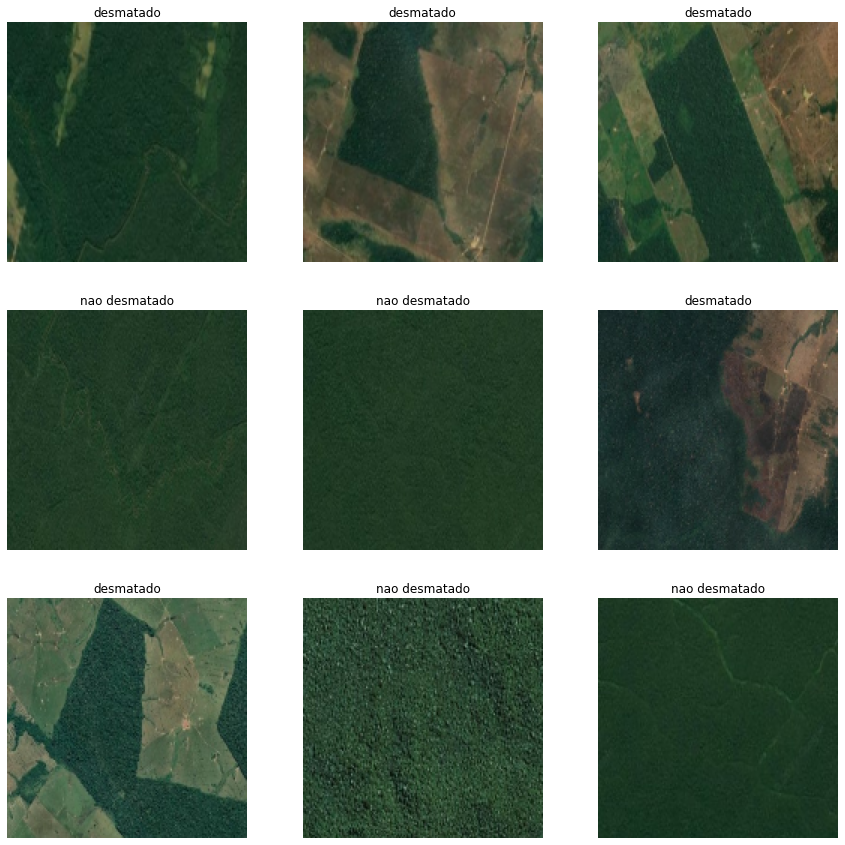

In [11]:
plot_dataset(dataset_train)

<Figure size 432x288 with 0 Axes>

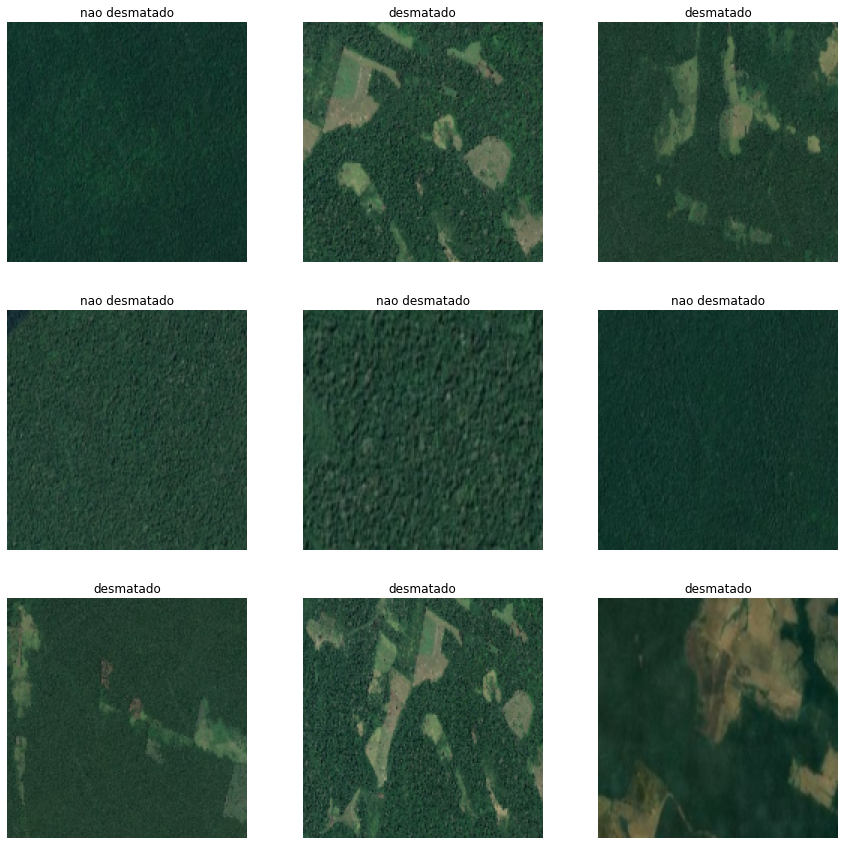

In [12]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

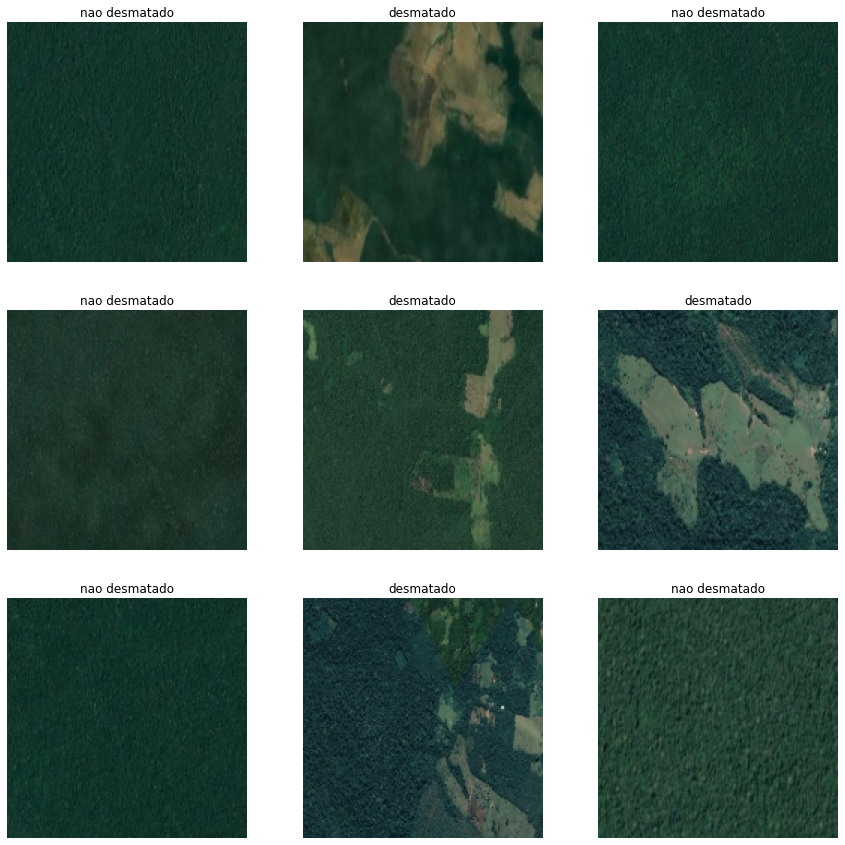

In [13]:
plot_dataset(dataset_test)

# Processamento de imagens
Realiza tranformações aleatórias no conjunto de imagens para termos mais variadade de inputs para treinar a IA

In [14]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [15]:
def plot_dataset_data_augmentation(dataset):
    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, _ in dataset.take(1):
        feature = features[0]

        for i in range(9):
            feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

<Figure size 432x288 with 0 Axes>

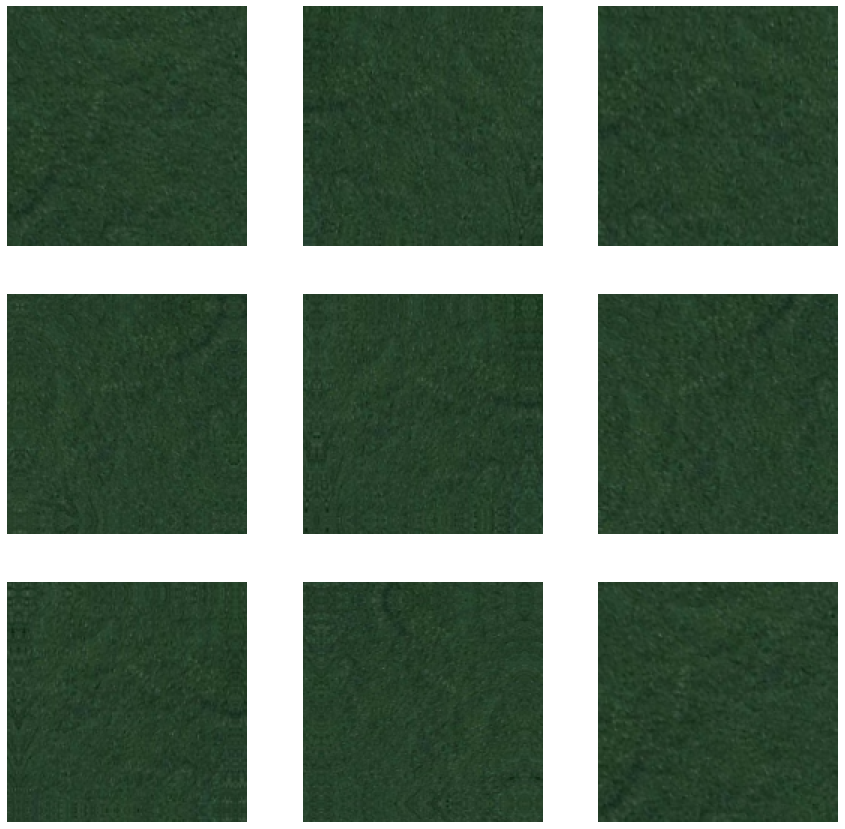

In [16]:
plot_dataset_data_augmentation(dataset_train)

In [17]:
rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1. / (image_color_channel_size / 2.), offset = -1, input_shape = image_shape)

# Importando Modelo MobileNetV2
Transferindo aprendizado do modelo pre-treinado para melhorar a classificação.

In [18]:
model_transfer_learning = tf.keras.applications.MobileNetV2(input_shape = image_shape, include_top = False, weights = 'imagenet')
model_transfer_learning.trainable = False

model_transfer_learning.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

In [20]:
model = tf.keras.models.Sequential([
    rescaling,
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

# Treinando o modelo

In [21]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs,
    callbacks = [
        early_stopping
    ]
)

Epoch 1/20
2/2 [==============================] - 6s 2s/step - loss: 0.6542 - accuracy: 0.6250 - val_loss: 0.7233 - val_accuracy: 0.5000
Epoch 2/20
2/2 [==============================] - 1s 651ms/step - loss: 0.6089 - accuracy: 0.7250 - val_loss: 0.7049 - val_accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 1s 564ms/step - loss: 0.5959 - accuracy: 0.6500 - val_loss: 0.6873 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 1s 567ms/step - loss: 0.5608 - accuracy: 0.6500 - val_loss: 0.6700 - val_accuracy: 0.5500
Epoch 5/20
2/2 [==============================] - 1s 583ms/step - loss: 0.5673 - accuracy: 0.6250 - val_loss: 0.6530 - val_accuracy: 0.5500
Epoch 6/20
2/2 [==============================] - 2s 967ms/step - loss: 0.5099 - accuracy: 0.8000 - val_loss: 0.6366 - val_accuracy: 0.5500
Epoch 7/20
2/2 [==============================] - 2s 943ms/step - loss: 0.5346 - accuracy: 0.7750 - val_loss: 0.6204 - val_accuracy: 0.5500
Epoch 8/20
2/2 [=======

# Resultados do treinamento
Desempenho da classificação do modelo com os datasets de treinamento e validação.

In [22]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

# Classificação do dataset de teste

In [26]:
dataset_test_loss, dataset_test_accuracy = model.evaluate(dataset_test)

print('Dataset Test Loss:     %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

1/1 [==============================] - 1s 825ms/step - loss: 0.5607 - accuracy: 0.6000
Dataset Test Loss:     0.5607033371925354
Dataset Test Accuracy: 0.6000000238418579


In [27]:
def plot_dataset_predictions(dataset):

    features, labels = dataset_test.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(9):

        plt.subplot(3, 3, i + 1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])

Labels:      [0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1]
Predictions: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


<Figure size 432x288 with 0 Axes>

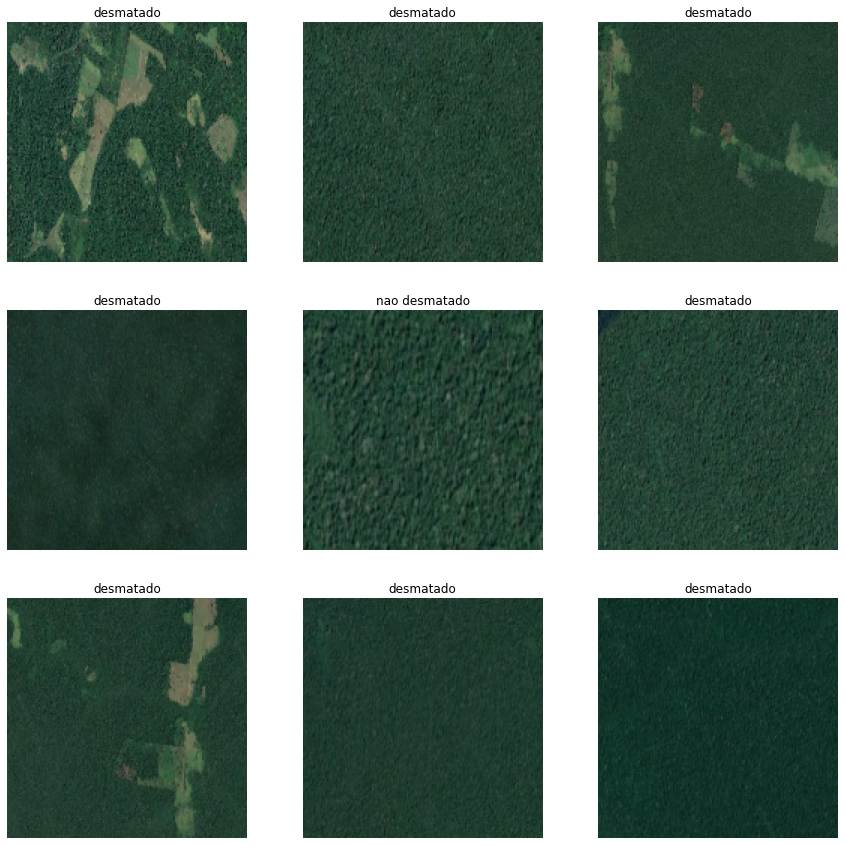

In [28]:
plot_dataset_predictions(dataset_test)

# Exportando modelo

In [29]:
model.save('model')

# Importando modelo
Usando o modelo para classificar novas imagens.

In [30]:
model = tf.keras.models.load_model('model')

In [31]:
def predict(image_file):

    image = tf.keras.preprocessing.image.load_img(image_file, target_size = image_size)

    plt.gcf().clear()
    plt.axis('off')
    plt.imshow(image)

    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)

    prediction = model.predict(image)[0][0]

    print('Prediction: {0} | {1}'.format(prediction, ('desmatado' if prediction < 0.5 else 'nao desmatado')))

In [32]:
def predict_url(image_fname, image_origin):

    image_file = tf.keras.utils.get_file(image_fname, origin = image_origin)
    return predict(image_file)

1/1 [==============================] - 2s 2s/step
Prediction: 0.20247118175029755 | desmatado


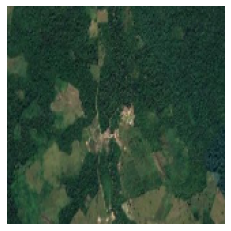

In [34]:
predict('/content/drive/MyDrive/rede neural/teste.jpg')